In [1]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [2]:
#%% Import Class & Functions

from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/ColabNotebooks')

# CNN Class
import Class.CNN as CNN

# Function
from Function.dSplit import dSplit
import Function.LossFunc as LF

Mounted at /content/drive


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
#%% Import data

# download EMNIST
dataset = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [6]:
#%% data preprocessing

# delete N/A category
dataset.classes = dataset.classes[1:]

# subtract 1 from the catefories-int
dataset.targets = dataset.targets - 1


Dataset EMNIST
    Number of datapoints: 124800
    Root location: emnist
    Split: Train
Size: torch.Size([124800, 28, 28])

Categories-str: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Categories-int: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]



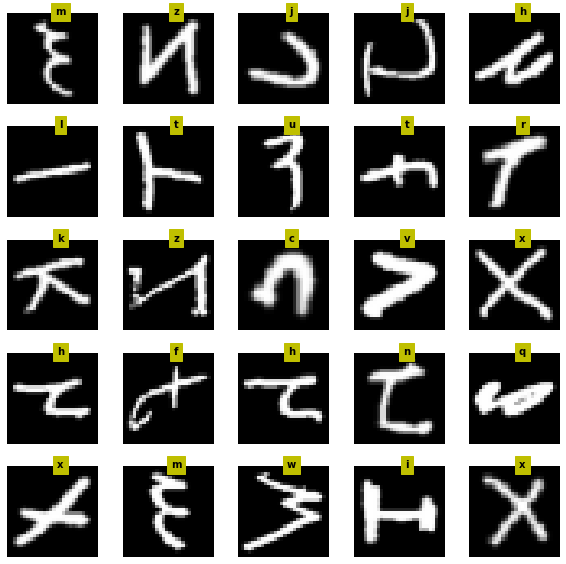

In [7]:
#%% Inspect Data

print(dataset)
print(f'Size: {dataset.data.shape}\n')
print(f'Categories-str: {dataset.classes}\n')
print(f'Categories-int: {np.unique(dataset.targets)}\n')

# plot random 10 pictures
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for ax in axs.flatten():

    # random index
    randidx = np.random.choice(len(dataset.targets))
    
    # extract image
    img = dataset.data[randidx, :, :]
    # label
    label = dataset.classes[dataset.targets[randidx]]
    
    # image
    ax.imshow(img, cmap='gray')
    ax.text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')


In [8]:
#%% Prepocessing

# Pytorch image size (N-batch, RGB, width, height)
# dat_X = torch.tensor(dataset.data)
# dat_X = dataset.data.permute(0, 3, 1, 2)
dat_X = dataset.data[:, None, :, :]
dat_y = dataset.targets

# Normalize
dat_X = dat_X / torch.max(dat_X)

# get all labels
labels = np.unique(dataset.classes)


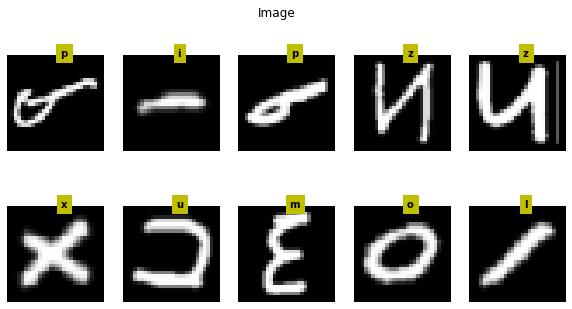

In [9]:
#%% plot image

randidx = np.random.choice(len(dat_y), size=10)

# plot
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle(f'Image')

for i, ax in enumerate(axs.flatten()):
    
    # apply the transform with the embedded transform
    img_t = dat_X[randidx[i], :, :, :]
    label_t = dataset.classes[dat_y[randidx[i]]]
    
    ax.imshow(dat_X[randidx[i], :, :, :].view(28, 28), cmap='gray')
    ax.text(16, 0, label_t, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')


In [10]:
#%% divide independent set
data_ss, data_test_ind, y_ss, y_test_ind = train_test_split(dat_X, dat_y, test_size=0.02)


# independent test set
# convert to tensor
data_test_ind_ts = data_test_ind.float()
y_test_ind_ts = y_test_ind.long() # .long() (integer and for cross-entropy, multi class)
# y_test_ind_ts = y_test_ind_ts.reshape((-1, 1)).long() # .float() and reshape only for binary
# y_test_ind_ts = torch.tensor(y_test_ind).reshape((-1, 1)).float()

# # convert to dataset and dataLoader
# Dataset_test = TensorDataset(data_test_ind_ts, y_test_ind_ts)
# DataLoader_test = DataLoader(Dataset_test, batch_size=Dataset_test.tensors[0].shape[0])

In [11]:
# %% train/dev dataset

# train set and dev set
# convert to tensor
data_ts = data_ss.float()
y_ts = y_ss.long() # .long() (integer and for cross-entropy, multi class)
# y_ts = y_ts.reshape((-1, 1)).long() # .float() and reshape only for binary
# y_ts = torch.tensor(y_ss).reshape((-1, 1)).float() # MSE (regression)

# params
dev_size = 0.2
b_size = 32

# train and dev set
DataLoader_train, DataLoader_dev, size = dSplit(data_ts, y_ts, model_test_size=dev_size, p_batch_size=b_size)


# # noise augmented set
# DataLoader_train_na, DataLoader_dev_na, _ = dSplit(data_ts_na, y_ts_na, model_test_size=test_size, p_batch_size=b_size)


# data size summary
d = {'Name': ['Total data', 'Training data', 'Devset data', 'Test data'],
     'Size': [dat_X.shape, size[0], size[1], data_test_ind_ts.shape]}

size_table = pd.DataFrame(data=d)
print(size_table)


# check data
# note: observe dataloader by iterate through them
# for X, y in DataLoader_train:
#   print(X.shape, y.shape)
# X, y

# X, y = next(iter(DataLoader_train))
# X, y

            Name                 Size
0     Total data  (124800, 1, 28, 28)
1  Training data   (97843, 1, 28, 28)
2    Devset data   (24461, 1, 28, 28)
3      Test data    (2496, 1, 28, 28)


In [12]:
# %% Create/Train model

# experiment parameters
in_chan = [2, 4, 8]
# dataLoaderSet = [[DataLoader_train, DataLoader_dev], [DataLoader_train_na, DataLoader_dev_na]]
out_chan = [8, 16, 32]

model_params_0 = in_chan
model_params_1 = out_chan

# model parameters
epochs = 5
dr = 0

# store result
# list_y_pred_params_0 = []
list_losses_train_params_0 = []
list_acc_ep_train_params_0 = []
list_acc_ep_test_params_0 = []
# list_w_histx_params_0 = []
list_w_histy_params_0 = []
# nParams     = np.zeros( (len(model_params_0), len(model_params_1)) )
time_proc = np.zeros((len(model_params_0), len(model_params_1)))

# store predicted data from trained model
list_y_pred_model_params_0 = []



# store the best trained model
bestModel = {'Accuracy':0,
             'net':None,
             'params': (None, None),
             }

# # Layers inputs
# convLayers = {
#         'conv0': {
#             'in_channels': 1,
#             'out_channels': 32,
#             'kernel_size': 3,
#             'stride': 1, # default
#             'padding': 1
#             },
#         'conv1': {
#             'in_channels': 32,
#             'out_channels': 64,
#             'kernel_size': 3,
#             'stride': 1, # default
#             'padding': 1
#             },
#         # 'conv2': {
#         #     'in_channels': 64,
#         #     'out_channels': 128,
#         #     'kernel_size': 3,
#         #     'stride': 1, # default
#         #     'padding': 1
#         #     }
#     }

poolLayers = {
        'pool0': {
            'kernel_size': 2,
            'stride': 2
            },
        'pool1': {
            'kernel_size': 2,
            'stride': 2
            },
        # 'pool2': {
        #     'kernel_size': 2,
        #     'stride': 2
        #     }
        }

# FF layer structure
hiddenLayers = {
        'hidden0': {
            'in_features': 50, 
            'out_features': 32
            },
        # 'hidden1': {
        #     'in_features': 32, 
        #     'out_features': 26
        #     },
    }



# run experiments
for (e, param_0) in enumerate(model_params_0):

    # store result
    res_losses_train = np.zeros((len(model_params_1), epochs))
    res_acc_ep_train = np.zeros((len(model_params_1), epochs))
    res_acc_ep_test = np.zeros((len(model_params_1), epochs))
    res_w_histx = np.zeros((epochs, 100, len(model_params_1)))
    res_w_histy = np.zeros((epochs, 100, len(model_params_1)))
    # res_y_pred_train = np.zeros( (batch_size, len(np.unique(labels)), len(model_params_1)) )
    
    # store predicted data from trained model
    y_pred_model = []

    for (i, param_1) in enumerate(model_params_1):

        # timer
        time_start = time.process_time()

        # Model class instance
        CNN_model = CNN.CNN_Class()
        
        # Layers inputs
        convLayers = {
                'conv0': {
                    'in_channels': 1,
                    'out_channels': param_1,
                    'kernel_size': 3,
                    'stride': 1, # default
                    'padding': 1
                    },
                'conv1': {
                    'in_channels': param_1,
                    'out_channels': param_0,
                    'kernel_size': 3,
                    'stride': 1, # default
                    'padding': 1
                    }
            }

        # construct layers
        CNN_model.setLayers(imgSize=data_ts.shape[2], 
                            convLayer=convLayers, 
                            poolLayer=poolLayers, 
                            hiddLayer=hiddenLayers,
                            feature_out=len(labels), 
                            conv_batch_norm=True
                            # printToggle=True
                            )
        
        # set parameters
        CNN_model.setParams(conv_dropout_rate=0.25,
                            dropout_rate=0,
                            learning_rate=0.001,
                            act_lib='torch',
                            conv_activation_fun='relu',  # activation function at convolution layers
                            pool_lib='torch.nn.functional',
                            pool_fun='max_pool2d',
                            activation_fun='relu',  # activation function at hidden layers (fully-connected layers)
                            optim_fun='Adam',
                            save_FeatMap=True
                            )

        dataloader_dict = {
            'DataLoader_train': DataLoader_train,
            'DataLoader_test': DataLoader_dev,
            }


        # send to GPU
        CNN_model.to(device)

        # result during training per each epoch
        _, model_losses_train, model_acc_ep_train, model_acc_ep_test, _, model_w_histx, model_w_histy = CNN_model.trainModel(
            **dataloader_dict,
            epochs=epochs,
            loss_function='cross-entropy',
            comp_acc_test=True,
            comp_w_hist=True,
            comp_w_change=False,
            device=device
        )

        res_losses_train[i, :] = model_losses_train.detach().numpy()

        res_acc_ep_train[i, :] = model_acc_ep_train.detach().numpy()

        # res_y_pred_train[:, :, i] = model_y_pred_train.detach().numpy()

        # accuracy comparing to test_set per each epoch
        res_acc_ep_test[i, :] = model_acc_ep_test.detach().numpy()

        # histogram weight
        res_w_histy[:, :, i] = model_w_histy

        # model parameters
        # nParams[e, i] = model_nParams

        # process time
        time_proc[e, i] = time.process_time() - time_start
        
        
    # Store result
    list_losses_train_params_0.append(res_losses_train)
    list_acc_ep_train_params_0.append(res_acc_ep_train)
    list_acc_ep_test_params_0.append(res_acc_ep_test)
    # list_w_histx_params_0.append(res_w_histx)
    list_w_histy_params_0.append(res_w_histy)
    # list_y_pred_params_0.append(res_y_pred_train)
    # list_y_pred_model_params_0.append(y_pred_model)
    
    # Store best model
    mean_acc = np.mean(list_acc_ep_test_params_0[-1][-1, :-5])
    if mean_acc > bestModel['Accuracy']:
        bestModel['Accuracy'] = mean_acc
        bestModel['net'] = copy.deepcopy(CNN_model.state_dict())
        bestModel['params'] = (e, i)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Density')

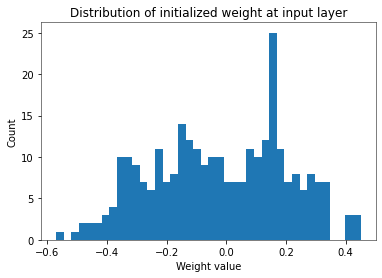

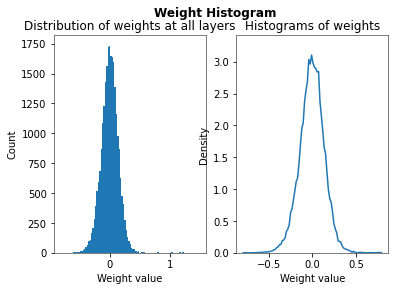

In [13]:
#%% explore the model's weight each layer

net_input_layer = vars(CNN_model.layers['conv0'])
net_input_layer_weight = CNN_model.layers['conv0'].weight.cpu()

# plot histogram of weight
plt.figure()
plt.hist(net_input_layer_weight.detach().flatten(), 40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized weight at input layer')


# weight at all layers
W = np.array([])

# get set of weights from each layer
for layer in CNN_model.layers:
    W = np.concatenate((W, CNN_model.layers[f'{layer}'].weight.cpu().detach().flatten().numpy() ))

# compute histogram
histy, histx = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
histx = (histx[1:] + histx[:-1])/2 # correct the dimension

# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Weight Histogram', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)

plt.subplot(1, 2, 1)
# plot histogram of weight (bar)
plt.hist(W, bins=100)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of weights at all layers')

plt.subplot(1, 2, 2)
plt.plot(histx, histy)
plt.ylim([0, np.max(histy)*1.1])
plt.title('Histograms of weights')
plt.xlabel('Weight value')
plt.ylabel('Density')


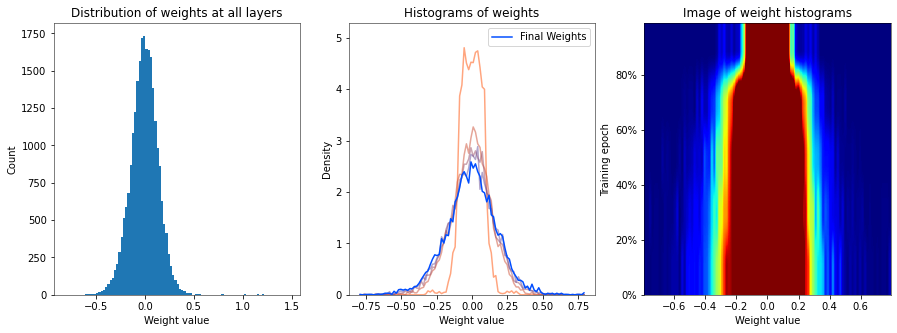

In [14]:
#%% Model's weight histogram of each epoch

# show the histogram of the weights

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

model_w_histy = list_w_histy_params_0[0][:, :, -1]

# plot histogram of weight (bar)
ax[0].hist(W, bins=100)
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of weights at all layers')


# plot histogram of weight (line)
w_len = len(model_w_histy)
for i in range(model_w_histy.shape[0]-1):
    ax[1].plot(model_w_histx, model_w_histy[i, :], color=[1-i/w_len, 0.3, i/w_len], alpha=0.5)
ax[1].plot(model_w_histx, model_w_histy[-1, :], color=[1-model_w_histy.shape[0]/w_len, 0.3, model_w_histy.shape[0]/w_len], label='Final Weights')
ax[1].set_title('Histograms of weights')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Density')
ax[1].legend()
ax[1].set_ylim([0, np.max(model_w_histy)*1.1])

# plot image of weight with epoch
ax[2].imshow(model_w_histy, vmin=0, vmax=0.8,
             extent=[model_w_histx[0], model_w_histx[-1], 0, 99], aspect='auto', origin='upper', cmap='jet')
ax[2].set_xlabel('Weight value')
ax[2].set_ylabel('Training epoch')
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax[2].set_title('Image of weight histograms')

plt.show()

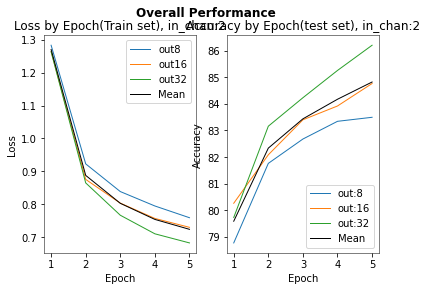

In [21]:
#%% plot model performance


# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot train-test acc-epoch by model
# plt.figure()
plt.subplot(1, 2, 1)
y_plot_1 = np.array(list_losses_train_params_0[0]).T
y_plot_2 = np.mean(np.array(list_losses_train_params_0[0]), axis=0)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss by Epoch(Train set), in_chan:{model_params_0[0]}')
plt.legend([f'out{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

plt.subplot(1, 2, 2)
y_plot_1 = np.array(list_acc_ep_test_params_0[0]).T
y_plot_2 = np.mean(np.array(list_acc_ep_test_params_0[0]), axis=0)
# plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy by Epoch(test set), in_chan:{model_params_0[0]}')
plt.legend([f'out:{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

